In [21]:
import pandas
from pathlib import Path
import os
import sys
from matplotlib import pyplot
import upsetplot
from collections import Counter

In [17]:
%matplotlib inline

In [2]:
LRSC = str(Path('~/proj/long-rna-seq-condor').expanduser())
if LRSC not in sys.path:
    sys.path.append(LRSC)
from woldrnaseq.gff2table import GFFParser, format_gtf_record

In [3]:
minimal_gtf = Path('genome/mm10-M21_minimal-male/10x_genes.gtf')
encode_gtf = Path('~/proj/genome/mm10-M21-male/gencode.vM21-tRNAs-ERCC.gff').expanduser()

In [4]:
encode_parser = GFFParser()
encode_parser.read_gff(encode_gtf)

gtf.shape (1879554, 9)


In [5]:
minimal_parser = GFFParser()
minimal_parser.read_gff(minimal_gtf)

gtf.shape (1704065, 9)


In [6]:
minimal_types = pandas.Series(Counter(minimal_parser.gtf['gene_biotype'])).sort_values(ascending=False).to_frame(name='count')
minimal_types

,count
protein_coding,1642941
lincRNA,38222
antisense,17995
IG_V_gene,2000
TR_V_gene,1350
IG_V_pseudogene,578
TR_J_gene,292
IG_C_gene,242
TR_V_pseudogene,115
TR_C_gene,113


In [14]:
def strip_version(gene_id):
    if isinstance(gene_id, str) and gene_id.startswith('ENSMUS'):
        return gene_id.split('.')[0]
    else:
        return gene_id
    
encode_gene_ids = set([strip_version(x) for x in encode_parser.gtf['gene_id']])

In [19]:
minimal_gene_ids = set(minimal_parser.gtf['gene_id'])

# Make our own GTF file that only includes the 10x records and the spike ins.

In [7]:
set(encode_parser.gtf['strand'])

{-1, 1}

In [8]:
format_gtf_record(encode_parser.gtf.iloc[0])

'chr1\tENSEMBL\ttRNA\t112349389\t112349461\t.\t+\t.\tgene_id "896"; transcript_id "896"; gene_type "Pseudo_tRNA"; transcript_type "896"; transcript_name "Pseudo_tRNA";'

In [9]:
det_minimal = Path('genome/mm10-M21_minimal-male/mm10-M21_minimal_det-male.gtf')

In [10]:
desired_types = set(minimal_types.index)
with open(det_minimal, 'wt') as outstream:
    for i, row in encode_parser.gtf.iterrows():
        if row.gene_type in desired_types or row.source == 'spikein':
            outstream.write(format_gtf_record(row))
            outstream.write(os.linesep)

In [11]:
encode_parser.gtf.shape

(1879554, 24)

In [12]:
det_minimal_parser = GFFParser(sep=' ')
det_minimal_parser.read_gff(det_minimal)

gtf.shape (1759465, 9)


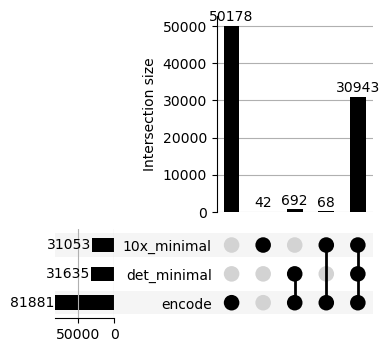

In [22]:
det_minimal_gene_ids = {strip_version(x) for x in det_minimal_parser.gtf['gene_id']}
upset_gene3_contents = upsetplot.from_contents({
    'encode': encode_gene_ids,
    '10x_minimal': minimal_gene_ids,
    'det_minimal': det_minimal_gene_ids,
})

f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_gene3_contents, fig=f, show_counts=True)

In [23]:
not_in_mine = minimal_gene_ids.intersection(encode_gene_ids).difference(det_minimal_gene_ids)
not_in_mine

{'ENSMUSG00000020812',
 'ENSMUSG00000034339',
 'ENSMUSG00000037603',
 'ENSMUSG00000040775',
 'ENSMUSG00000043346',
 'ENSMUSG00000044424',
 'ENSMUSG00000044645',
 'ENSMUSG00000049124',
 'ENSMUSG00000051255',
 'ENSMUSG00000052730',
 'ENSMUSG00000055795',
 'ENSMUSG00000058064',
 'ENSMUSG00000061062',
 'ENSMUSG00000062036',
 'ENSMUSG00000062083',
 'ENSMUSG00000062742',
 'ENSMUSG00000066057',
 'ENSMUSG00000066983',
 'ENSMUSG00000067608',
 'ENSMUSG00000068604',
 'ENSMUSG00000069379',
 'ENSMUSG00000071033',
 'ENSMUSG00000071052',
 'ENSMUSG00000071273',
 'ENSMUSG00000073371',
 'ENSMUSG00000073448',
 'ENSMUSG00000073532',
 'ENSMUSG00000073640',
 'ENSMUSG00000079382',
 'ENSMUSG00000081512',
 'ENSMUSG00000085287',
 'ENSMUSG00000086154',
 'ENSMUSG00000086875',
 'ENSMUSG00000087112',
 'ENSMUSG00000091230',
 'ENSMUSG00000091285',
 'ENSMUSG00000091449',
 'ENSMUSG00000091695',
 'ENSMUSG00000091742',
 'ENSMUSG00000091775',
 'ENSMUSG00000091968',
 'ENSMUSG00000092097',
 'ENSMUSG00000092178',
 'ENSMUSG00

In [24]:
print('{:20}  {:20}  {:30}'.format('gene_id', 'minimal type', 'encode type'))
for to_check in not_in_mine:
    records = minimal_parser.gtf[minimal_parser.gtf['gene_id'] == to_check]
    row = records.loc[records.first_valid_index()]
    encode = encode_parser.gtf[[x.startswith(to_check) for x in encode_parser.gtf['gene_id']]]
    encode_row = encode.loc[encode.first_valid_index()]
    print('{:20}  {:20}  {:30}'.format(row.gene_id, row.gene_biotype, encode_row.gene_type))

gene_id               minimal type          encode type                   
ENSMUSG00000097787    lincRNA               bidirectional_promoter_lncRNA 
ENSMUSG00000101966    lincRNA               processed_pseudogene          
ENSMUSG00000071273    protein_coding        processed_pseudogene          
ENSMUSG00000055795    protein_coding        processed_pseudogene          
ENSMUSG00000091695    protein_coding        processed_pseudogene          
ENSMUSG00000097746    lincRNA               processed_transcript          
ENSMUSG00000096361    protein_coding        processed_pseudogene          
ENSMUSG00000062742    protein_coding        processed_pseudogene          
ENSMUSG00000058064    protein_coding        processed_pseudogene          
ENSMUSG00000020812    protein_coding        processed_transcript          
ENSMUSG00000095369    lincRNA               processed_transcript          
ENSMUSG00000073448    protein_coding        processed_pseudogene          
ENSMUSG00000086154    lin

# Check the generated transcript files

In [ ]:
def get_fasta_headers(filename, strip_version=False):
    headers = set()
    with open(filename, 'rt') as instream:
        for line in instream:
            if line[0] == '>':
                end_of_line = -1
                if strip_version:
                    end_of_line = line.find('.')
                header = line[1:end_of_line]
                headers.add(header)
    return headers

In [ ]:
minimal_transcripts = get_fasta_headers('genome/mm10-M21_minimal-male/rsem.transcripts.fa')

In [ ]:
full_transcripts = get_fasta_headers(Path('~/proj/genome/mm10-M21-male/rsem.transcripts.fa').expanduser())

In [ ]:
upset_rsem = upsetplot.from_contents({
    'encode': full_transcripts,
    '10x_minimal': minimal_transcripts,
})

In [ ]:
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_rsem, fig=f, show_counts=True)